In [42]:
import numpy as np
import matplotlib
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import PIL.Image
import tensorflow as tf
from tensorflow.keras import layers, models
from keras import backend as K
import seaborn as sn
import matplotlib
from tensorflow.keras.models import load_model

In [43]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)
else:
    print('No GPUs detected')

1 Physical GPUs, 1 Logical GPUs


In [44]:
tf.autograph.set_verbosity(0)

In [45]:
def load_data_tf(data_path: str, img_shape=(256,256), batch_size: int=64):
    train_ds = tf.keras.utils.image_dataset_from_directory(
        data_path,
        validation_split=0.3,
        subset="training",
        label_mode='categorical',
        seed=123,
        image_size=img_shape,
        batch_size=batch_size)
    val_ds = tf.keras.utils.image_dataset_from_directory(
        data_path,
        validation_split=0.3,
        subset="validation",
        label_mode='categorical',
        seed=123,
        image_size=img_shape,
        batch_size=batch_size)
    return train_ds, val_ds

In [46]:
train_dataset, test_val_ds = load_data_tf('cov_data', img_shape = (256,256), batch_size=8)

Found 4575 files belonging to 3 classes.
Using 3203 files for training.
Found 4575 files belonging to 3 classes.
Using 1372 files for validation.


In [47]:
val_dataset = test_val_ds.take(86)
test_dataset = test_val_ds.skip(86)

In [48]:
print(f"{train_dataset.cardinality().numpy()}, {val_dataset.cardinality().numpy()}, {test_dataset.cardinality().numpy()}")

401, 86, 86


In [55]:
model_alex = tf.keras.models.Sequential([
  layers.Input(shape=(256,256,3)),
  layers.Resizing(height=224, width=224),
  layers.Rescaling(1./255),
    # 1st conv
  tf.keras.layers.Conv2D(96, (11,11),strides=(4,4), input_shape=(224, 224, 3)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Activation('relu'),
  tf.keras.layers.MaxPooling2D(2, strides=(2,2)),
    # 2nd conv
  tf.keras.layers.Conv2D(256, (5,5),strides=(1,1),padding="same"),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Activation('relu'),
     # 3rd conv
  tf.keras.layers.Conv2D(384, (3,3),strides=(1,1),padding="same"),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Activation('relu'),
    # 4th conv
  tf.keras.layers.Conv2D(384, (3,3),strides=(1,1),padding="same"),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Activation('relu'),
    # 5th Conv
  tf.keras.layers.Conv2D(256, (3, 3), strides=(1, 1),padding="same"),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Activation('relu'),
  tf.keras.layers.MaxPooling2D(2, strides=(5, 5)),
  # To Flatten layer
  tf.keras.layers.Flatten(),
  # To FC layer 1
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  #To FC layer 2
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(3, activation='softmax')
])

In [56]:
model_alex.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_8 (Resizing)       (None, 224, 224, 3)       0         
                                                                 
 rescaling_8 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_40 (Conv2D)          (None, 54, 54, 96)        34944     
                                                                 
 batch_normalization_40 (Bat  (None, 54, 54, 96)       384       
 chNormalization)                                                
                                                                 
 activation_40 (Activation)  (None, 54, 54, 96)        0         
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 27, 27, 96)       0         
 g2D)                                                   

In [57]:
model_alex.compile(optimizer='sgd',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
history = model_alex.fit(train_dataset, epochs=80, validation_data=val_dataset)

Epoch 1/100
401/401 [==============================] - 36s 70ms/step - loss: 1.3066 - accuracy: 0.6522 - val_loss: 0.6197 - val_accuracy: 0.7907
Epoch 2/100
401/401 [==============================] - 28s 70ms/step - loss: 0.6765 - accuracy: 0.7315 - val_loss: 0.5078 - val_accuracy: 0.8110
Epoch 3/100
401/401 [==============================] - 30s 74ms/step - loss: 0.5961 - accuracy: 0.7596 - val_loss: 0.4750 - val_accuracy: 0.8299
Epoch 4/100
401/401 [==============================] - 31s 75ms/step - loss: 0.5647 - accuracy: 0.7793 - val_loss: 0.4805 - val_accuracy: 0.8227
Epoch 5/100
401/401 [==============================] - 31s 76ms/step - loss: 0.5133 - accuracy: 0.7955 - val_loss: 0.7538 - val_accuracy: 0.7093
Epoch 6/100
401/401 [==============================] - 31s 77ms/step - loss: 0.4982 - accuracy: 0.8130 - val_loss: 0.4681 - val_accuracy: 0.8227
Epoch 7/100
401/401 [==============================] - 31s 77ms/step - loss: 0.4793 - accuracy: 0.8217 - val_loss: 0.4956 - val_ac

In [49]:
class ParametrisedCompatibility(tf.keras.layers.Layer):

    def __init__(self, kernel_regularizer=None, **kwargs):
        super(ParametrisedCompatibility, self).__init__(**kwargs)
        self.regularizer = kernel_regularizer

    def build(self, input_shape):
        self.u = self.add_weight(name='u', shape=(input_shape[0][3], 1), initializer='uniform', regularizer=self.regularizer, trainable=True)
        super(ParametrisedCompatibility, self).build(input_shape)

    def call(self, x):  # add l and g. Dot the sum with u.
        return K.dot(K.map_fn(lambda lam: (lam[0]+lam[1]),elems=(x),dtype='float32'), self.u)

    def compute_output_shape(self, input_shape):
        return (input_shape[0][0], input_shape[0][1], input_shape[0][2])

AlexNet with attention

In [50]:
inp = tf.keras.layers.Input(shape=(256,256,3))
l_resize = tf.keras.layers.Resizing(height=224, width=224) (inp)
l_rescale = tf.keras.layers.Rescaling(1./255) (l_resize)
    # 1st conv
x = tf.keras.layers.Conv2D(96, (11,11),strides=(4,4), input_shape=(224, 224, 3)) (l_rescale)
x = tf.keras.layers.BatchNormalization() (x)
x = tf.keras.layers.Activation('relu') (x)
x = tf.keras.layers.MaxPooling2D(2, strides=(2,2)) (x)
x = tf.keras.layers.Conv2D(256, (5,5),strides=(1,1),padding="same") (x)
x = tf.keras.layers.BatchNormalization() (x)
x = tf.keras.layers.Activation('relu') (x)
'''First feature extraction for attention'''
local_1 = layers.Dense(units=256, activation=None, name='conn_1') (x)
     # 3rd conv
x = tf.keras.layers.Conv2D(384, (3,3),strides=(1,1),padding="same") (x)
x = tf.keras.layers.BatchNormalization() (x)
x = tf.keras.layers.Activation('relu') (x)


    # 4th conv
x = tf.keras.layers.Conv2D(384, (3,3),strides=(1,1),padding="same") (x)
x = tf.keras.layers.BatchNormalization() (x)
x = tf.keras.layers.Activation('relu') (x)
'''Second feature extraction for attention'''
local_2 = layers.Dense(units=256, activation=None, name='conn_2') (x)

    # 5th Conv
x = tf.keras.layers.Conv2D(256, (3, 3), strides=(1, 1),padding="same") (x)
x = tf.keras.layers.BatchNormalization() (x)
x = tf.keras.layers.Activation('relu') (x)
x = tf.keras.layers.MaxPooling2D(2, strides=(5, 5)) (x)
'''Third feature extraction for attention'''
local_3 = layers.Dense(units=256, activation=None, name='conn_3') (x)

  # To Flatten layer
x = tf.keras.layers.Flatten() (x)
  # To FC layer 1
x = tf.keras.layers.Dense(256, activation='relu') (x)
g = tf.keras.layers.Dropout(0.5) (x)

''' Calculate compatibility scores '''
c_1 = layers.Lambda(lambda lam: K.squeeze(K.map_fn(fn=lambda xy: K.dot(xy[0], xy[1]), elems=(lam[0], K.expand_dims(lam[1], -1)), dtype=tf.float32), 3), name='cdp1')([local_1, g])
flat_1 = layers.Flatten() (c_1)
act_1 = layers.Softmax() (flat_1)
c_2 = layers.Lambda(lambda lam: K.squeeze(K.map_fn(fn=lambda xy: K.dot(xy[0], xy[1]), elems=(lam[0], K.expand_dims(lam[1], -1)), dtype=tf.float32), 3), name='cdp2')([local_2, g])
flat_2 = layers.Flatten() (c_2)
act_2 = layers.Softmax() (flat_2)
c_3 = layers.Lambda(lambda lam: K.squeeze(K.map_fn(fn=lambda xy: K.dot(xy[0], xy[1]), elems=(lam[0], K.expand_dims(lam[1], -1)), dtype=tf.float32), 3), name='cdp3')([local_3, g])
flat_3 = layers.Flatten() (c_3)
act_3 = layers.Softmax() (flat_3)

''' Multiply the local outputs by the compatibility scores '''
rs_1 = layers.Reshape((-1,256)) (local_1)
g_a_1 = layers.Lambda(lambda lam: K.squeeze(K.batch_dot(K.expand_dims(lam[0], 1), lam[1]), 1), 
             name='ga1')([act_1,rs_1])

rs_2 = layers.Reshape((-1,256)) (local_2)
g_a_2 = layers.Lambda(lambda lam: K.squeeze(K.batch_dot(K.expand_dims(lam[0], 1), lam[1]), 1), 
             name='ga2')([act_2,rs_2])

rs_3 = layers.Reshape((-1,256)) (local_3)
g_a_3 = layers.Lambda(lambda lam: K.squeeze(K.batch_dot(K.expand_dims(lam[0], 1), lam[1]), 1), 
             name='ga3')([act_3,rs_3])

l_concat = layers.Concatenate() ([g_a_1,g_a_2, g_a_3]) #""" # concatenate the three attention outputs"""

out = tf.keras.layers.Dense(units=3, activation='softmax') (l_concat)

In [51]:
model_alex_att = models.Model(inputs=inp, outputs=out)
model_alex_att.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 resizing_7 (Resizing)          (None, 224, 224, 3)  0           ['input_8[0][0]']                
                                                                                                  
 rescaling_7 (Rescaling)        (None, 224, 224, 3)  0           ['resizing_7[0][0]']             
                                                                                                  
 conv2d_35 (Conv2D)             (None, 54, 54, 96)   34944       ['rescaling_7[0][0]']      

In [52]:
model_alex_att.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [53]:
history = model_alex_att.fit(train_dataset, epochs=100,
              callbacks = tf.keras.callbacks.EarlyStopping(patience=6),
              validation_data=val_dataset)

Epoch 1/100
236/401 [================>.............] - ETA: 28s - loss: 0.9745 - accuracy: 0.5318

KeyboardInterrupt: 

In [34]:
test_loss, test_acc = model_alex_att.evaluate(test_dataset, verbose=2)

86/86 - 5s - loss: 0.3113 - accuracy: 0.9108 - 5s/epoch - 61ms/step


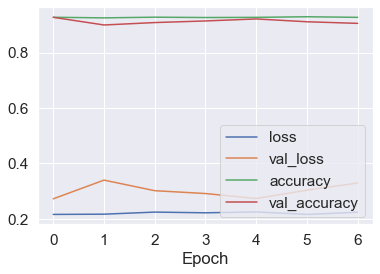

In [35]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

In [36]:
hist_df = pd.DataFrame(history.history)
hist_csv_file = 'history_alex_att_l2_1.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

In [66]:
model_folder = 'model_alex_att_l2_test'
model_alex_att.save(model_folder)

INFO:tensorflow:Assets written to: model_alex_att_l2_test\assets


In [25]:
model = tf.keras.models.load_model('model_alex_att_l2_test')

Cause: could not parse the source code of <function <lambda>.<locals>.<lambda> at 0x0000013B58A3A1F0>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [26]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 resizing (Resizing)            (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['resizing[0][0]']               
                                                                                                  
 conv2d (Conv2D)                (None, 54, 54, 96)   34944       ['rescaling[0][0]']          

Performance evaluation

In [27]:
model = model_alex_att

In [28]:
model.evaluate(test_dataset)

Cause: could not parse the source code of <function <lambda>.<locals>.<lambda> at 0x0000013B61F43DC0>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
86/86 [==============================] - 32s 75ms/step - loss: 0.3158 - accuracy: 0.9108


[0.3158091604709625, 0.9108186960220337]

In [29]:
labels = []
images = []
for image, label in test_dataset.unbatch():
    images.append(image)
    labels.append(label)

In [30]:
images = np.array(images)
images.shape

(684, 256, 256, 3)

In [31]:
labels = np.array(labels)
labels.shape

(684, 3)

In [32]:
y_pred = model.predict(images)

Cause: could not parse the source code of <function <lambda>.<locals>.<lambda> at 0x0000013B63BFE670>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [33]:
labels = np.argmax(labels,axis=-1)
predictions=np.argmax(y_pred,axis=-1)


In [34]:
np.sum(labels==predictions)

625

In [35]:
def conf_matrix(model, X_test, y_test):
  
  # Predict
    y_pred = model.predict(X_test, batch_size=32, verbose=1)
    y_pred_bool = np.argmax(y_pred, axis=1)
    y_test_bool = y_test #, axis=1)
    
  # Confusion matrix
    
    labels = ('normal', 'covid', 'pneumonia')
    df_confusion = confusion_matrix(y_true = y_test_bool, y_pred = y_pred_bool)
    precision = np.round(df_confusion/df_confusion.sum(axis = 0), 2)
    recall = np.round((df_confusion.T/df_confusion.sum(axis = 1)).T, 2)
    
    matplotlib.rcParams.update({'font.size': 15})
    fig, ax = plt.subplots(1, 2, figsize=(12, 5), frameon = False)
    sn.heatmap(recall, cmap='YlGnBu', vmin=0.0, vmax=1.0, # cmap = 'BuPu'
                annot=True, ax=ax[0])
    sn.heatmap(precision, cmap='YlGnBu', vmin=0.0, vmax=1.0,
                annot=True, ax=ax[1])
    fig.suptitle('AlexNet with attention')
    ax[0].set_title('Recall', fontsize = 14)
    ax[1].set_title('Precision', fontsize = 14)
    ax[0].set_yticklabels(labels, va="center")
    ax[1].set_yticklabels(labels, va="center")
    ax[0].set_xticklabels(labels, va="center")
    ax[1].set_xticklabels(labels, va="center")
    
    ax[0].set_ylabel("True value", fontsize = 12)
    ax[0].set_xlabel("Predicted value", fontsize = 12)
    ax[1].set_ylabel("True value", fontsize = 12)
    ax[1].set_xlabel("Predicted value", fontsize = 12)

    plt.show()

22/22 [==============================] - 3s 119ms/step


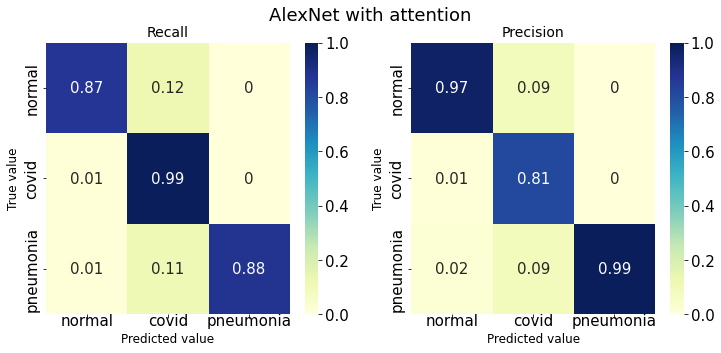

In [36]:
conf_m = conf_matrix(model=model, X_test=images, y_test=labels)

In [37]:
precision_score(y_true=labels, y_pred=predictions, labels=[1],average=None)

array([0.81294964])

In [38]:
recall_score(y_true=labels, y_pred=predictions, labels=[1],average=None)

array([0.98689956])

In [77]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

model_builder = tf.keras.applications.xception.Xception
preprocess_input = tf.keras.applications.xception.preprocess_input
decode_predictions = tf.keras.applications.xception.decode_predictions

#print([layer.name for layer in model.layers])
def predict_display(img_path):
    #print(model.layers[-1].activation) #
    #model.layers[-1].activation = None
   
    #print(img_path)
    img_array = preprocess_input(get_img_array(img_path, size=(256,256)))
    # preds = model.predict(img_array)
    # #print(preds)
    # print(preds[0], img_path)
    # if np.argmax(preds[0]) > 0:
    #     print(np.argmax(preds[0]))
    heatmap = make_gradcam_heatmap(img_array, model, 'conv2d',pred_index=1)
    
    # Display heatmap
    plt.matshow(heatmap)
    plt.show()


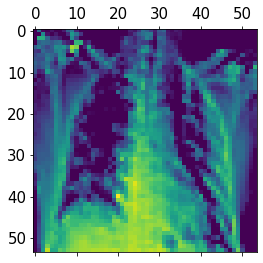

In [78]:
impath = 'cov_data\\covid\\COVID19(569).jpg'
predict_display(impath)